In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from utils.load_data import load_data
from utils.processing import build_features
from baseline_model.preprocessing import preprocess_data

In [7]:
df = load_data(False, True)


/home/ec2-user/SageMaker/hisa-trainer-injury/src/utils/load_data.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_yr = pd.read_csv(data_location)
/home/ec2-user/SageMaker/hisa-trainer-injury/src/utils/load_data.py:16: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_yr = pd.read_csv(data_location)


In [8]:
df = build_features(df)
df, cols_for_model = preprocess_data(df)

In [11]:
LONG_LAYOFF_THRESHOLD = 165 # 99th percentile
def get_prev_race_features(df: pd.DataFrame) -> pd.DataFrame:
    
    df['race_date'] = pd.to_datetime(df['race_date'])
    df = df.sort_values(by=['registration_number', 'race_date'])
    df = df.rename(columns={'distance_id': 'race_distance'})

    df['previous_race_date'] = df.groupby('registration_number')['race_date'].shift(1)
    df['previous_race_dnf'] = df.groupby('registration_number')['dnf'].shift(1)
    df['previous_race_vet_scratched'] = df.groupby('registration_number')['vet_scratched'].shift(1)
    df['previous_race_badly_beaten'] = df.groupby('registration_number')['badly_beaten'].shift(1)
    df['previous_race_breakdown'] = df.groupby('registration_number')['breakdown'].shift(1)
    df['previous_race_scratched'] = df.groupby('registration_number')['scratched'].shift(1)
    df['previous_race_distance'] = df.groupby('registration_number')['race_distance'].shift(1)
    df['previous_surface'] = df.groupby('registration_number')['surface'].shift(1)
    df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days


    df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
    df['distance_jump'] = np.where(
        df['distance_delta'] > 200,
        1,
        0
    )

    df['rest_after_dnf'] = np.where(
        df['previous_race_dnf'] == 1,
        df['days_since_last_race'],
        np.nan
    )

    df['rest_after_scratch'] = np.where(
        df['previous_race_scratched'] == 1,
        df['days_since_last_race'],
        np.nan
    )

    df['surface_change'] = np.where(
        df['surface'] != df['previous_surface'],
        1,
        0
    )

    df['long_layoff'] = np.where(
        df['days_since_last_race'] > LONG_LAYOFF_THRESHOLD,
        1,
        0
    )
    
    return df

In [12]:
df = get_prev_race_features(df)

In [13]:
COLS_FOR_SMOOTHING = ['dnf', 'scratched', 'vet_scratched', 'badly_beaten', 'breakdown']

In [14]:
from scipy.stats import ks_2samp

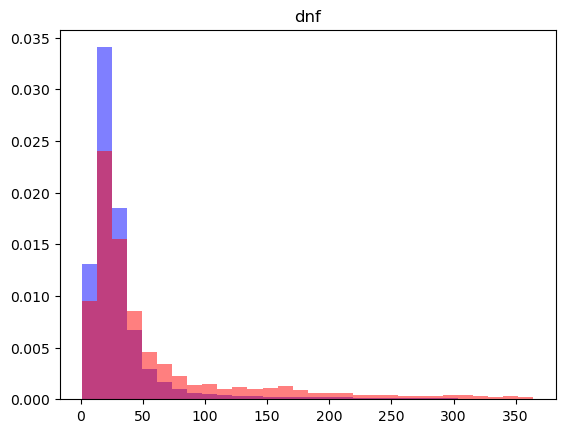

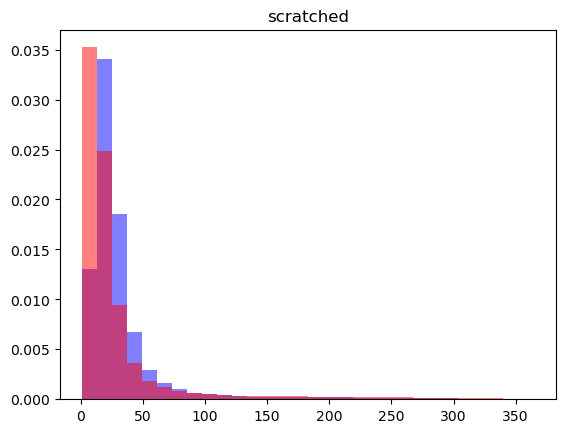

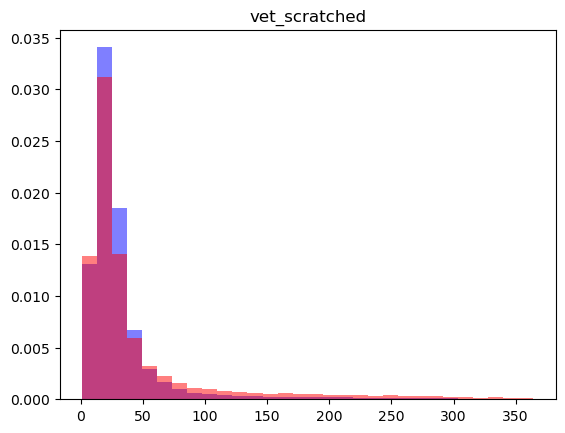

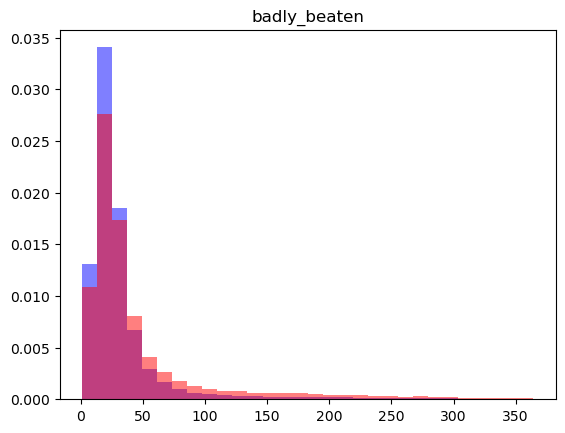

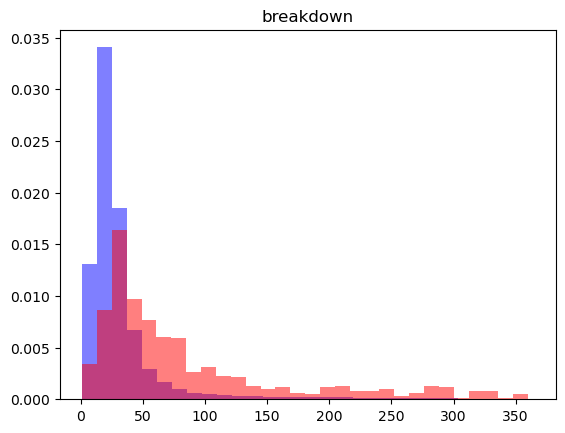

In [15]:
neg = df[(df['previous_race_dnf'] == 0) & (df['previous_race_scratched'] == 0) & (df['previous_race_badly_beaten'] == 0)]
neg_vals = [v for v in neg['days_since_last_race'] if (v < 365 and v > 0)]
ks_stats = []
for c in COLS_FOR_SMOOTHING:
    pos = df[df[f'previous_race_{c}'] == 1]
    plt.figure()
    pos_vals = [v for v in pos['days_since_last_race'] if (v < 365 and v > 0)]
    ks = ks_2samp(neg_vals, pos_vals, alternative='greater')
    ks_stats.append({
        'value': c,
        'statistic': ks[0],
        'p_value': ks[1],
        'statistic_location': ks.statistic_location,
        'statistic_sign': ks.statistic_sign,
        'neg_vals_mean': np.mean(neg_vals),
        'pos_vals_mean': np.mean(pos_vals),
        'neg_vals_median': np.median(neg_vals),
        'pos_vals_median': np.median(pos_vals),
        'ratio': np.median(pos_vals) / np.median(neg_vals)
#        'pos_vals_mean': np.mean(neg_vals),
#        'pos_vals_mean': np.mean(pos_vals),
    })
    plt.hist(neg_vals, color='blue', alpha=0.5, density=True, bins=30)
    plt.hist(pos_vals, color='red', alpha=0.5, density=True, bins=30)
    plt.title(c)
    plt.savefig(f'output/models/{c}_days_to_next_race.png')

In [16]:
pd.DataFrame(ks_stats).to_csv('output/models/ks_results.csv')

In [19]:
k = pd.DataFrame(ks_stats)
k['ratio2'] = k['pos_vals_mean'] / k['neg_vals_mean']
k

,value,statistic,p_value,statistic_location,statistic_sign,neg_vals_mean,pos_vals_mean,neg_vals_median,pos_vals_median,ratio,ratio2
0,dnf,0.202891,8.974561e-215,38.0,1,33.558088,57.329729,22.0,30.0,1.363636,1.708373
1,scratched,0.011136,3.608492e-18,98.0,1,33.558088,28.975342,22.0,15.0,0.681818,0.863438
2,vet_scratched,0.088881,0.000000e+00,50.0,1,33.558088,45.434691,22.0,23.0,1.045455,1.353912
3,badly_beaten,0.121435,0.000000e+00,30.0,1,33.558088,46.824060,22.0,27.0,1.227273,1.395314
4,breakdown,0.458833,4.385926e-94,31.0,1,33.558088,84.807843,22.0,53.5,2.431818,2.527195


In [20]:

DNF_RATIO = 1.708373
VET_SCRATCH_RATIO = 1.353912
BADLY_BEATEN_RATIO = 1.395314
BREAKDOWN_RATIO = 2.527195

In [21]:
df['target'] = df['dnf'] * DNF_RATIO + df['vet_scratched'] * VET_SCRATCH_RATIO + df['badly_beaten'] * BADLY_BEATEN_RATIO + df['breakdown'] * BREAKDOWN_RATIO
df['target_binary'] = np.clip(df['target'], 0, 1)
df.head(2)

,race_date,track_id,race_number,race_type,race_distance,distance_unit,surface,course_type,purse,track_condition,...,previous_surface,days_since_last_race,distance_delta,distance_jump,rest_after_dnf,rest_after_scratch,surface_change,long_layoff,target,target_binary
1430663,2018-05-13,WIL,7,ALW,2400,F,T,B,15000.0,SF,...,NaN,NaN,NaN,0,NaN,NaN,1,0,1.708373,1.0
1430664,2018-04-28,GLN,1,STK,3200,F,T,B,100000.0,SF,...,NaN,NaN,NaN,0,NaN,NaN,1,0,0.000000,0.0


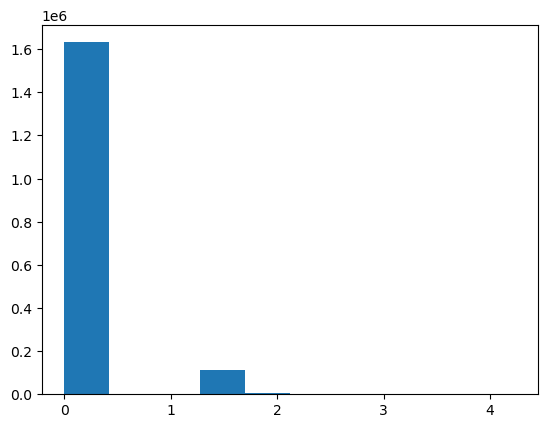

In [22]:
plt.hist(df['target'])
plt.show()

In [41]:

TARGET = 'target_binary'

In [24]:
! pip install xgboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 7.0 MB/s eta 0:00:00:00:0100:01


In [42]:
from utils.processing import create_train_test_split
from models.model_builds import build_linear_classifier, build_xgb_classifier, build_linear_regressor, build_xgb_regressor
from models.eval import evaluate_classification, evaluate_regression, get_feature_importance


In [43]:



data = create_train_test_split(df[cols_for_model + [TARGET]], test_size=0.2, valid_size=0.1, split_column='registration_number', target_column=TARGET)

if 'binary' in TARGET:
    reg_model = build_linear_classifier(data)
    xgb_model = build_xgb_classifier(data)
else:
    reg_model = build_linear_regressor(data)
    xgb_model = build_xgb_regressor(data)

In [47]:

metrics = []
for model in [reg_model, xgb_model]:
    for dset in ['train', 'test', 'valid']:
        X = data[f'X_{dset}']
        y = data[f'y_{dset}']
        y_pred = model.predict(X)
        
        if 'binary' in TARGET:
            y_pred_proba = model.predict_proba(X)[:, 1]
            metric = evaluate_classification(y, y_pred, y_pred_proba)
        else:
            metric = evaluate_regression(y, y_pred)
        metric['model'] = model.__class__.__name__
        metric['dataset'] = dset
        metric = {'model': metric.pop('model'), 'dataset': metric.pop('dataset'), **metric}
        metrics.append(metric)  

metrics = pd.DataFrame(metrics)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/SageMaker/hisa-trainer-injury/src/models/eval.py:23: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2 * (precision * recall) / (precision + recall)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision

In [48]:
metrics

,model,dataset,accuracy,precision,recall,f1,auroc,auprc,threshold
0,LogisticRegressionCV,train,0.928884,0.000000,0.000000,0.000000,0.565719,0.086259,0.073939
1,LogisticRegressionCV,test,0.929187,0.000000,0.000000,0.000000,0.567654,0.086453,0.074664
2,LogisticRegressionCV,valid,0.929478,0.000000,0.000000,0.000000,0.565489,0.085317,0.087795
3,XGBClassifier,train,0.928886,0.571429,0.000091,0.000183,0.590451,0.099486,0.077201
4,XGBClassifier,test,0.929184,0.000000,0.000000,0.000000,0.589682,0.097797,0.525131
5,XGBClassifier,valid,0.929472,0.333333,0.000081,0.000161,0.585011,0.096179,0.078806


In [31]:
lin_reg_ft_imp = get_feature_importance(lin_reg_model, data['X_train'])
lin_reg_ft_imp

course_type_M         7.014400e-01
track_sealed_N        1.639786e-01
track_sealed_Y        1.619326e-01
course_type_D         6.156381e-02
sex_F                 1.614961e-02
sex_H                 7.715484e-03
weather_L             4.738113e-03
surface_D             3.928757e-03
weather_C             3.703013e-03
sex_C                 3.782062e-04
track_condition_GD    0.000000e+00
track_condition_FT    0.000000e+00
race_type_DTR         0.000000e+00
race_type_DBY         0.000000e+00
race_type_MDN         0.000000e+00
race_type_SPI         0.000000e+00
surface_T            -3.660546e-16
sex_M                -3.795798e-03
age                  -6.361494e-03
sex_G                -8.932887e-03
race_type_ALW        -3.473348e-02
race_type_STK        -7.170448e-02
dtype: float64

In [32]:
xgb_reg_ft_imp = get_feature_importance(xgb_model, data['X_train'])
xgb_reg_ft_imp

course_type_M         0.335796
course_type_D         0.226747
track_sealed_Y        0.161463
track_sealed_N        0.094494
race_type_STK         0.041004
race_type_ALW         0.033533
age                   0.020053
surface_D             0.014067
sex_F                 0.012059
sex_G                 0.011141
sex_H                 0.010708
weather_L             0.010576
sex_C                 0.010238
weather_C             0.009563
sex_M                 0.008556
race_type_DTR         0.000000
track_condition_GD    0.000000
race_type_DBY         0.000000
race_type_MDN         0.000000
race_type_SPI         0.000000
surface_T             0.000000
track_condition_FT    0.000000
dtype: float32

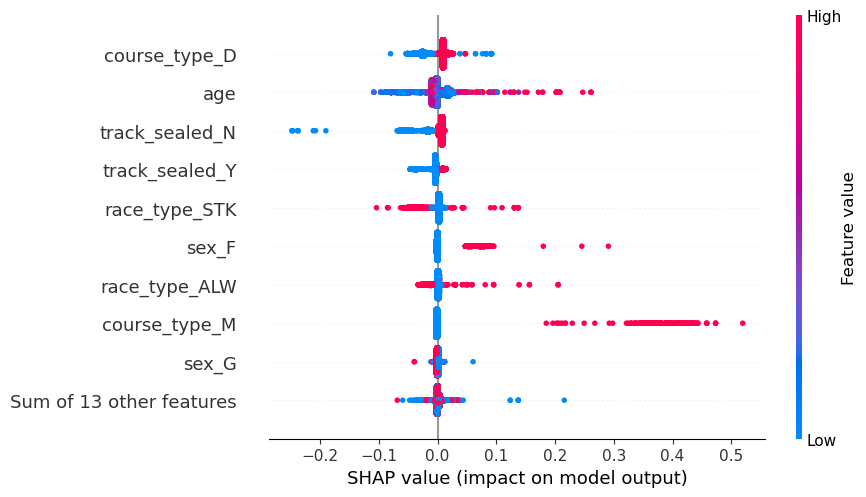

In [33]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgb_model)


explanation = explainer(df[xgb_model.feature_names_in_].sample(frac=0.05))
shap.plots.beeswarm(explanation, max_display=10)


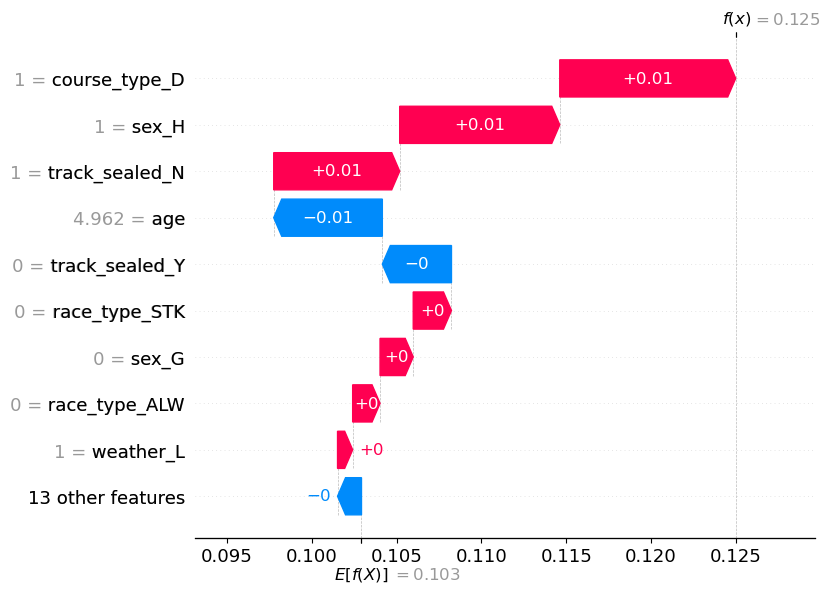

In [35]:
shap.plots.waterfall(explanation[501])

In [ ]:
df['prediction'] = xgb_model.predict(df[xgb_model.feature_names_in_])
df['prediction'] = np.clip(
    df['prediction'], 
    0, .15
)
df['prediction'] = df['prediction'] * 100 - 6.5

In [ ]:
plt.hist(df['prediction'], bins=30)
plt.xlabel('Risk Prediction')
plt.ylabel('Entries')
plt.title('Risk Predictions')

In [ ]:
df[cols_for_model + [TARGET, 'prediction']].sort_values('prediction')

In [ ]:
df[TARGET_BINARY].sum()/ df.shape[0]
# = 0.06548652395395947

In [ ]:
def get_xDNF(df: pd.DataFrame) -> pd.DataFrame:
    scratches = df[df['scratch_indicator'] == 'Y']
    scratches['xDNF'] = np.nan
    racers = df[df['scratch_indicator'] != 'Y']
    racers['xDNF'] = baseline_inference(df)

    df = pd.concat([racers, scratches])
    
    return df

In [ ]:
# fit exponential to df['length_behind_at_finish']
from scipy.stats import expon

params = expon.fit(df['length_behind_at_finish'])

# get 95th percentile
expon.ppf(0.95, *params)

In [ ]:
def get_prev_race_features(df: pd.DataFrame) -> pd.DataFrame:
    
    df['race_date'] = pd.to_datetime(df['race_date'])
    df = df.sort_values(by=['registration_number', 'race_date'])
    df = df.rename(columns={'distance_id': 'race_distance'})

    df['previous_race_date'] = df.groupby('registration_number')['race_date'].shift(1)
    df['previous_race_dnf'] = df.groupby('registration_number')['dnf'].shift(1)
    df['previous_race_scratch'] = df.groupby('registration_number')['scratched'].shift(1)
    df['previous_race_distance'] = df.groupby('registration_number')['race_distance'].shift(1)
    df['previous_surface'] = df.groupby('registration_number')['surface'].shift(1)
    df['days_since_last_race'] = (df['race_date'] - df['previous_race_date']).dt.days


    df['distance_delta'] = df['race_distance'] - df['previous_race_distance']
    df['distance_jump'] = np.where(
        df['distance_delta'] > 200,
        1,
        0
    )

    df['rest_after_dnf'] = np.where(
        df['previous_race_dnf'] == 1,
        df['days_since_last_race'],
        np.nan
    )

    df['rest_after_scratch'] = np.where(
        df['previous_race_scratch'] == 1,
        df['days_since_last_race'],
        np.nan
    )

    df['surface_change'] = np.where(
        df['surface'] != df['previous_surface'],
        1,
        0
    )

    # maybe should account for covid
    df['long_layoff'] = np.where(
        df['days_since_last_race'] > 365,
        1,
        0
    )
    
    return df

    

In [ ]:
def fit_params(grouped_df: pd.DataFrame) -> pd.Series:
    try:
        params = lognorm.fit(grouped_df['days_since_last_race'].dropna())
    except Exception as e:
        # print(e)
        params = (None, None, None)

    trainer_params = pd.Series(params, index=['lognorm_p1', 'lognorm_p2', 'lognorm_p3'])
    
    return trainer_params



In [ ]:
def get_first_long(df: pd.DataFrame) -> pd.DataFrame:
    
    first_long = df[df['race_distance'] > 800].sort_values(by=['race_date']).groupby(['registration_number', 'trainer_id']).first().reset_index()

    
    trainer_first_long = first_long.groupby(['trainer_id']).agg({
            'age': 'median'
        }).reset_index().rename(columns={'age': 'first_long_age'})

    return trainer_first_long


In [ ]:
def group_trainer_data(df: pd.DataFrame) -> pd.DataFrame:
    trainers = df.groupby(['trainer_id']).agg({
        'race_number': 'count',
        'registration_number': 'nunique',
        'scratched': 'sum',
        'dnf': 'sum',
        'age': 'min',
        'lasix': 'sum',
        'bute': 'sum',
        'days_since_last_race': ['min', 'median'],
        'rest_after_dnf': 'median',
        'rest_after_scratch': 'median',
        'distance_jump': 'sum',
        'surface_change': 'sum',
        'long_layoff': 'sum',
        'badly_beaten': 'sum',
    }).reset_index()

    trainers.columns = ['trainer_id',
    'n_entries', 'unique_horses', 'scratched', 'dnf', 'min_age', 'lasix', 'bute', 'days_since_last_race_min', 'days_since_last_race_median', 
    'rest_after_dnf_median', 'rest_after_scratch_median', 'distance_jump', 'surface_changes', 'long_layoffs',
    'badly_beaten'
    ]

    trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
    trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']
    trainers['badly_beaten_pct'] = trainers['badly_beaten'] / trainers['n_entries']
    trainers['lasix_pct'] = trainers['lasix'] / trainers['n_entries']
    trainers['bute_pct'] = trainers['bute'] / trainers['n_entries']
    
    # TODO
    # trainers['dnf_per_entry_smooth'] = None
    # trainers['scratches_per_entry'] = None
    
    
    return trainers


In [ ]:
def create_features(df: pd.DataFrame, suffix: str = None) -> pd.DataFrame:

    df = extract_features(df)
    df = get_prev_race_features(df)
    trainer_params = df.groupby('trainer_id').apply(fit_params)
    first_long = get_first_long(df)
    trainers = group_trainer_data(df)
    trainers = trainers.merge(first_long, on=['trainer_id'], how='left')
    trainers = trainers.merge(trainer_params, on=['trainer_id'], how='left')
    
    for c in trainers.columns:
        if 'lognorm' in c:
            trainers[c] = round(trainers[c], 5)
    
    if suffix:
        trainers.columns = [c + f'_{suffix}' for c in trainers.columns]
        trainers = trainers.rename(columns={
            f'trainer_id_{suffix}': 'trainer_id'
        })
    
    return trainers


In [ ]:
def create_targets(df: pd.DataFrame): 
    
    df = extract_features(df)
    
    trainers = df.groupby('trainer_id').agg({
        'race_number': 'count',
        'dnf': 'sum',
        'scratched': 'sum',
        'badly_beaten': 'sum',
        #'long_layoff': 'sum',
    })
    
    trainers = trainers.rename(columns={
        'race_number': 'n_entries'
    }).reset_index()
    
    trainers['scratches_per_entry'] = trainers['scratched'] / trainers['n_entries']
    trainers['dnf_per_entry'] = trainers['dnf'] / trainers['n_entries']
    trainers['badly_beaten_pct'] = trainers['badly_beaten'] / trainers['n_entries']
    
    # TODO
    # trainers['dnf_per_entry_smooth'] = None
    # trainers['scratches_per_entry'] = None
    
    trainers = trainers[['trainer_id', 'n_entries', 'dnf_per_entry']].rename(columns={
        'dnf_per_entry': 'target',
        'n_entries': 'target_n_entries',
    })
    
    return trainers

In [ ]:

prediction_dates = [
    '2022-07-01', 
    '2022-12-01'
]


df = load_data(False)
df = get_xDNF(df)
df['race_date'] = pd.to_datetime(df['race_date'])
FEATURE_DAY_DELTA = 365
TARGET_DAY_DELTA = 180

full_model_df = pd.DataFrame()
for prediction_date in prediction_dates:
    feature_end_date = datetime.datetime.strptime(prediction_date, '%Y-%m-%d')
    feature_start_date = feature_end_date - datetime.timedelta(days=FEATURE_DAY_DELTA)
    
    target_start_date = feature_end_date + datetime.timedelta(days=1)
    target_end_date = target_start_date + datetime.timedelta(days=TARGET_DAY_DELTA)
    
    df_features = df[(df['race_date'] >= feature_start_date) & (df['race_date'] <= feature_end_date)]
    df_target = df[(df['race_date'] >= target_start_date) & (df['race_date'] <= target_end_date)]
    
    features = create_features(df_features, str(FEATURE_DAY_DELTA))
    targets = create_targets(df_target)
    
    df_date = features.merge(targets, how='inner', on='trainer_id')
    full_model_df = pd.concat([full_model_df, df_date], ignore_index=True)
    

for n_entries in [50, 100, 250]:
    # for each n_entries, group by trainer id and keep the most recent n_entries
    # then create features and targets

    df_features = df.groupby('trainer_id').apply(lambda x: x.tail(n_entries)).reset_index()


In [ ]:
from models.model_builds import build_xgb_regressor, build_linear_regressor
from baseline_model.preprocessing import create_train_test_split

In [ ]:
data = create_train_test_split(full_model_df, test_size=0.2, valid_size=0.1, split_column='trainer_id')

lin_reg_model = build_linear_regressor(data)
#xgb_model = build_xgb_classifier(data)


# TODOs


## Baseline Model
- lambda


## Risk Model
- preprocess
    - distance
    - beyer? 
    - smoothed values

- workouts
    




In [ ]:

df['previous_performance_figure'] = df.groupby('registration_number')['performance_figure'].shift(1)
df['performance_figure'] = df['performance_figure'].str.replace('-', '0').astype(float, errors='ignore')
df['previous_performance_figure'] = df['previous_performance_figure'].str.replace('-', '0').astype(float, errors='ignore')

prev_perf = df.dropna(subset=['previous_performance_figure', 'performance_figure'])
prev_perf = prev_perf[(prev_perf['previous_performance_figure']) > 0 & (prev_perf['performance_figure'] > 0)]
prev_perf['performance_figure_ratio'] = prev_perf['performance_figure'] / prev_perf['previous_performance_figure']


In [ ]:
# baseline testing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
from baseline_model.load_data import load_data
from baseline_model.preprocessing import preprocess_data

In [ ]:
df = load_data(True)
df = preprocess_data(df)
df = df.drop(columns=['dnf', 'registration_number'])

In [ ]:
with open('output/models/baseline_log_reg_model.pkl', 'rb') as f:
    log_reg_model = pickle.load(f)

with open('output/models/baseline_xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [ ]:
ft_imp = []
for col, coef in zip(log_reg_model.feature_names_in_, log_reg_model.coef_[0]):
    ft_imp.append({
        'feature': col,
        'importance': coef
    })

ft_imp = pd.DataFrame(ft_imp)
ft_imp = ft_imp.sort_values(by='importance')

plt.barh(ft_imp['feature'], ft_imp['importance'])
plt.show()


In [ ]:
ft_imp = []
for col, coef in zip(xgb_model.feature_names_in_, xgb_model.feature_importances_):
    ft_imp.append({
        'feature': col,
        'importance': coef
    })

ft_imp = pd.DataFrame(ft_imp)
ft_imp = ft_imp.sort_values(by='importance')

plt.barh(ft_imp['feature'], ft_imp['importance'])
plt.show()

In [ ]:
# use shap to get feature importance
import shap

shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(df[xgb_model.feature_names_in_])



In [ ]:
# plot the SHAP values
shap.summary_plot(shap_values, df[xgb_model.feature_names_in_], plot_type='bar')

In [ ]:
# plot the SHAP values for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], df[xgb_model.feature_names_in_].iloc[0,:])


In [ ]:
# plot shap for two features
shap.dependence_plot('surface_D', shap_values, df[xgb_model.feature_names_in_])

In [ ]:
# plot predictions vs actual color cmap by data['target_n_entries]

plt.figure()
plt.scatter(xgb_model.predict(df[xgb_model.feature_names_in_]), df['target'], c=df['target_n_entries'], cmap='viridis')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# add r2 score to plot
plt.text(0.1, 0.9, f'R2: {xgb_model.score(df[xgb_model.feature_names_in_], df["target"])}', fontsize=12)
plt.colorbar()





In [ ]:
plt.figure()
plt.hist(preds, bins=30)
# vertical black dotted line for mean
plt.axvline(np.mean(preds), color='black', linestyle='--')
# red dotted lines at +1 and -1 stdev 
plt.axvline(np.mean(preds) + np.std(preds), color='red', linestyle='--')
plt.axvline(np.mean(preds) - np.std(preds), color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Count')
plt.title('Predictions Histogram')

# add text in upper right with mean and stdev
# only show 3 decimal places
plt.text(0.6, 0.9, f'Mean: {np.mean(preds):.3f}', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.6, 0.85, f'Stdev: {np.std(preds):.3f}', fontsize=12, transform=plt.gcf().transFigure)

In [4]:
from build_baseline_model import main

ImportError: cannot import name 'TARGET' from 'baseline_model.constants' (/home/ec2-user/SageMaker/hisa-trainer-injury/src/baseline_model/constants.py)